In [34]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

In [2]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt

dirName = "/Users/mfisherlevine/Desktop/CBP_talk_plots"

def ContourPlot(data, n_contours=100):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig = plt.figure(figsize=(1.05*10,10))
    h = plt.contourf(x,y,data,n_contours, cmap=plt.cm.gist_heat)
    ax = fig.add_subplot(111)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    plt.show()
    
def SurfacePlot(data, downsample_factor=50, zlim=None):
    from mpl_toolkits.mplot3d import axes3d
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(xx, yy, data, rstride=downsample_factor, cstride=downsample_factor, cmap=plt.cm.gist_heat)
    if zlim is not None: ax.set_zlim(zlim[0],zlim[1])
    plt.show()
    
def ContourAndSurfacePlot(data, n_contours=100, downsample_factor=50, zlim=None):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    fig = plt.figure(figsize=(22,10))
    ax = fig.add_subplot(121)
    h = plt.contourf(x,y,data,n_contours, cmap=plt.cm.gist_heat)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)
    
    ax = fig.add_subplot(122, projection='3d')
    surf = ax.plot_surface(xx, yy, data, rstride=downsample_factor, cstride=downsample_factor, cmap=plt.cm.gist_heat)
    if zlim is not None: ax.set_zlim(zlim[0],zlim[1])
    plt.show()
    
def random_sign():
    return (-1.)**np.random.randint(0,2) #upper bound is exclusive

# def ChipFromXY(x, y):
#     if x>=(N_CCDS_PER_SIDE*N_PIX_PER_CCD) or y>=(N_CCDS_PER_SIDE*N_PIX_PER_CCD):
#         raise ValueError('Pixel coordinate lies outside the focal plane')
#     return int(x//N_PIX_PER_CCD), int(y//N_PIX_PER_CCD)

In [3]:
N_PIX_PER_CCD = 500
N_CCDS_PER_SIDE = 3

x = np.linspace(-1, 1, N_PIX_PER_CCD*N_CCDS_PER_SIDE)
y = np.linspace(-1, 1, N_PIX_PER_CCD*N_CCDS_PER_SIDE)

x_chip = np.linspace(-1, 1, N_PIX_PER_CCD)
y_chip = np.linspace(-1, 1, N_PIX_PER_CCD)

# pixel coordinates
# using complex makes bounds inclusive, and avoids having to do 1./n as it implies the number of points
# xx, yy = np.mgrid[-1:1:complex(N_PIX_PER_CCD*N_CCDS_PER_SIDE), -1:1:complex(N_PIX_PER_CCD*N_CCDS_PER_SIDE)]#.reshape(2,-1).T
# pixels = np.vstack((xx.flatten(), yy.flatten())).T
xx, yy = np.meshgrid(x, y)
xx_chip, yy_chip = np.meshgrid(x_chip, y_chip)


# additive part of flat field screen illumination
illum = 0.025*(xx**2 + yy**2)
# true per-pixel sensitivity variation (assuming all pixels are the same size)
nPerCCD = N_PIX_PER_CCD    # we have 4 chips in the following S_qe prescription

Quantum efficiency map:


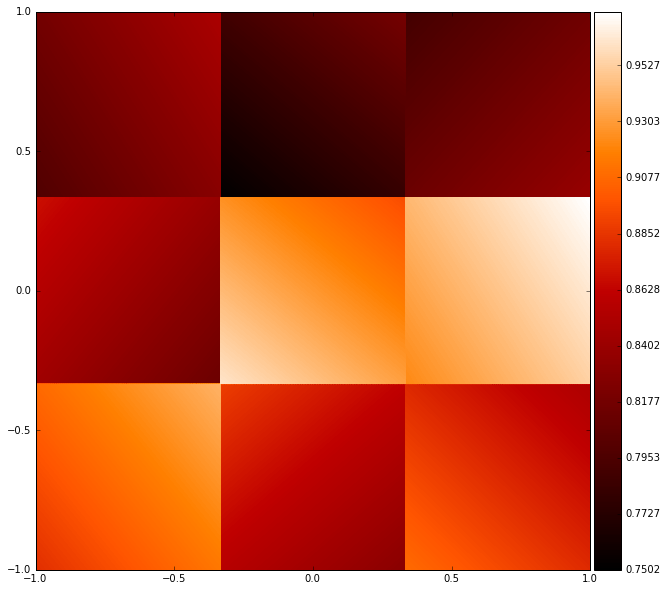

Quantum efficiency histogram:
Min QE = 75.0%
Max QE = 97.4%


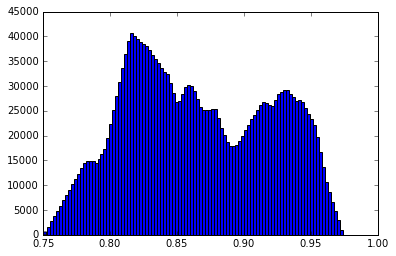

In [32]:
# generate some random gradients and nominal QE values
# QE gradients are in the range 0.01 - 0.02
# Slopes are assigned at random in both x and y directions
# nominal QE is randomly assigned between 80 and 100%

x_gradients = [random_sign()*np.random.randint(500,1000)/50000. for _ in range(N_CCDS_PER_SIDE**2)]
y_gradients = [random_sign()*np.random.randint(500,1000)/50000. for _ in range(N_CCDS_PER_SIDE**2)]
nom_qes =     [np.random.randint(8000,10000)/10000. for _ in range(N_CCDS_PER_SIDE**2)]

S_qe = np.zeros_like(illum)
for i in range(N_CCDS_PER_SIDE):
    for j in range(N_CCDS_PER_SIDE):
        # linear index for the gradients and nominal QEs
        index = j + (N_CCDS_PER_SIDE*i)
        
        # make the QE for the chip
        chip = 0.95*((x_gradients[index]*xx_chip + y_gradients[index]*yy_chip) + nom_qes[index])
       
        # Tile the chips onto the raft
        S_qe[i*N_PIX_PER_CCD:(i+1)*N_PIX_PER_CCD, j*N_PIX_PER_CCD:(j+1)*N_PIX_PER_CCD] = chip

# Check the QE plot 
print 'Quantum efficiency map:'
# ColorPlot(S_qe,n_contours=1000)
ContourAndSurfacePlot(S_qe, n_contours=1000, zlim=(0,1))
print 'Quantum efficiency histogram:'
plt.hist(S_qe.flatten(), bins=100)
print 'Min QE = %.1f%%'%(100*np.min(S_qe))
print 'Max QE = %.1f%%'%(100*np.max(S_qe))

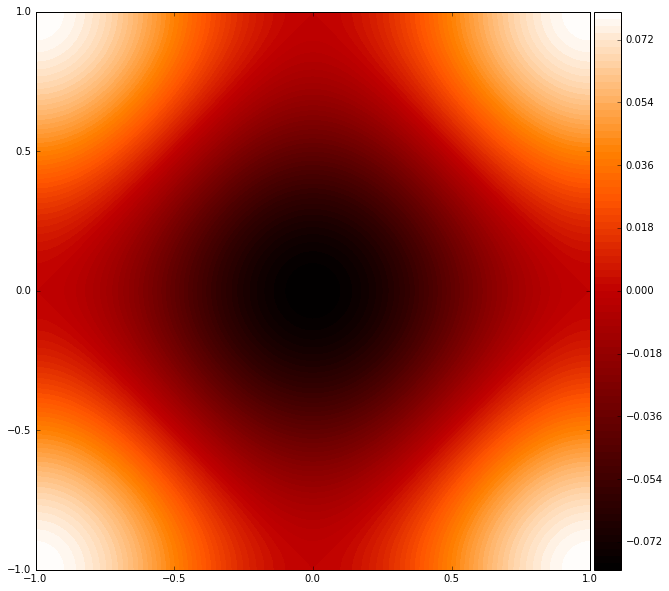

In [5]:
A = -(0.04*np.cos(xx*np.pi)+0.04*np.cos(yy*np.pi))
ColorPlot(A)

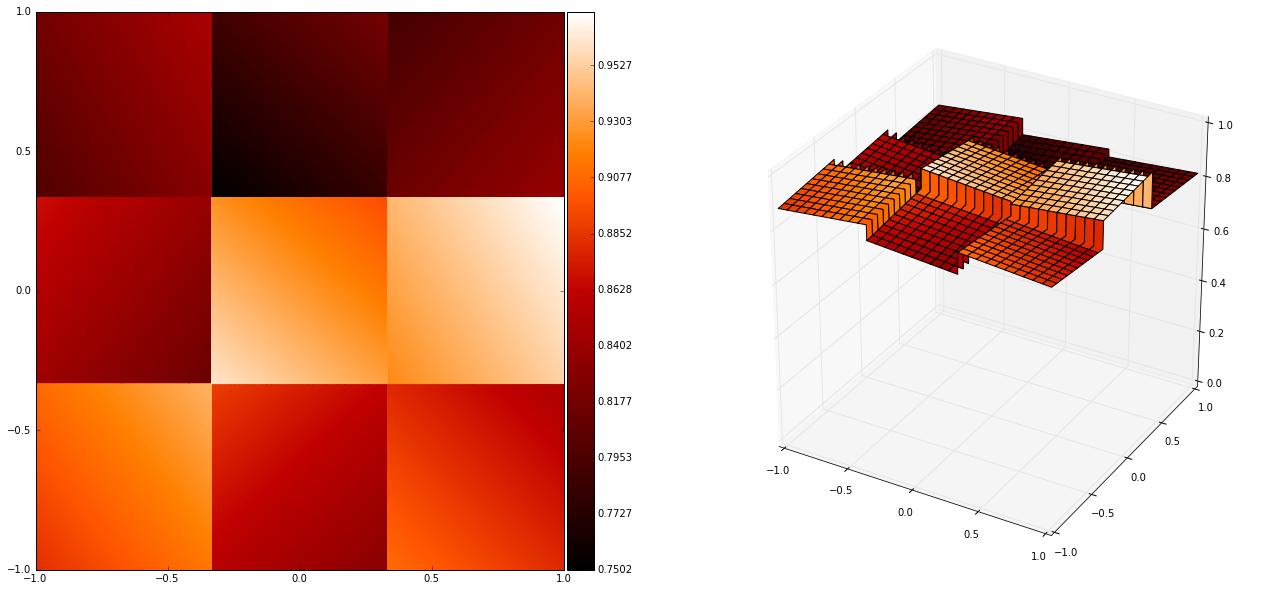

In [ ]:

# additive term
# MFL changed amplitude so that it's not identical to i at boundaries --> doesn't cancel perfectly
A = -0.07*np.cos(2*ib*np.pi)

# optical distortion
# MFL changed the sign
S_optical = 1 + 0.1*ib**4

# MFL changed to higher freq than CBP sampling
# and made non-commensurate with all other pitches
S_ccd = 1 + 0.01*np.sin(73*ib*np.pi) 

# sensitivity allowing for pixel size variation
calS = S_qe*S_optical*S_ccd
# measured flat field
Fb = (1 + i + A)*calS

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ib, S_qe, label='$S^{qe}$')
plt.plot(ib, S_optical, label='$S^{optical}$')
plt.plot(ib, S_ccd, label='$S^{ccd}$')

# plt.plot(ib, 1.3*Fb, label='$Fb$')

scale=1.25
plt.plot(ib, scale*calS, label='$%g{\cal S}_b$' % scale)

plt.legend(loc='best', fontsize=30).draggable()
foo = plt.ylim(0.5, 1.3)

plt.savefig(os.path.join(dirName, "S.pdf"))

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(ib, np.ones_like(ib), label='$1$')
plt.plot(ib, 1 + i, label='$1 + i$')
# plt.plot(ib, 1 + A, label='$1 + A$')
plt.plot(ib, 1 + i + A, label='$1 + i + A_b$')
if False:
    scale = 1.3
    plt.plot(ib, scale*calS, label='$%g{\cal S}_b$' % scale)

plt.plot(ib, Fb, label='${\cal F}_b$')

plt.legend(loc='best', fontsize=25).draggable()
foo = plt.ylim(0.5, 1.25)

plt.savefig(os.path.join(dirName, "F_b.png"))

In [ ]:
from scipy import interpolate

nSampleCBP = 5            # number of CBP spots per chip

# true/false array of which points are sampled in CCD space
samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
#
# Estimate the illumination from the interpolated CBP data
rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
# And fit it with a smoothing spline
interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
# and use that to estimate the true calS
estCalS = Fb/interpIllum(ib)

plt.figure(figsize=(12,8))
plt.plot(ib, Fb, label='${\cal F}_b$')

plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP_b$')
plt.plot(ib, interpCalS(ib), label=r'$fit(CBP_b)$')

plt.plot(ib, rawEstIllum, label='${\cal F}_b/fit(CBP_b)$')
plt.plot(ib, interpIllum(ib), label='$fit({\cal F}_b/fit(CBP_b))$')

plt.plot(ib, calS + 0.3)
plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

plt.legend(loc='best',  fontsize=22, ncol=2)
foo = plt.ylim(0.5, 1.35)

plt.savefig(os.path.join(dirName, "CBP.pdf"))

In [ ]:
from scipy import interpolate

nSampleCBP = 2            # number of CBP spots per chip

# true/false array of which points are sampled in CCD space
samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
#
# Estimate the illumination from the interpolated CBP data
rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
# And fit it with a smoothing spline
interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
# and use that to estimate the true calS
estCalS = Fb/interpIllum(ib)

plt.figure(figsize=(12,8))
plt.plot(ib, Fb, label='$Flat\endash field \ screen$')

plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP \ points$')
plt.plot(ib, interpCalS(ib), label=r'$Spline \ fit \ to \ CBP$')

plt.plot(ib, rawEstIllum, label='$Estimated \ illumination \ correction$')
plt.plot(ib, interpIllum(ib), label='$Smoothed \ \ illumination \ correction$')

plt.plot(ib, calS + 0.3)
plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

plt.legend(loc='best',  fontsize=20, ncol=2)
foo = plt.ylim(0.5, 1.35)

plt.savefig(os.path.join(dirName, "CBP.pdf"))

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
plt.plot(ib, (estCalS/calS), label=r'$\tilde{\cal F}_b/{\cal F}_s$')
plt.axhline(1.0, color='k', ls='--')
maxval = np.max(estCalS/calS)
plt.axhline(maxval, color='r', ls=':')

_ = plt.title(r'Flat-field illumination correction residuals')
# ticks = list(ax.get_yticks())#.append(maxval)
# ticks = [np.round(_,4) for _ in ax.get_yticks()]
# ticks.append(np.round(maxval,5))
# ax.set_yticks(ticks)
# plt.ylim(0.998,1.0005)
plt.legend(loc='best',  fontsize=30)


plt.savefig(os.path.join(dirName, "CBP-errors.pdf"))

In [ ]:
PLOT = False

max_errors = []
for nSampleCBP in range(1,100):            # number of CBP spots per chip

    # true/false array of which points are sampled in CCD space
    samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

    interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
    #
    # Estimate the illumination from the interpolated CBP data
    rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
    # And fit it with a smoothing spline
    interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
    # and use that to estimate the true calS
    estCalS = Fb/interpIllum(ib)

    maxval = np.max(estCalS/calS)

    if PLOT:
        plt.figure(figsize=(12,8))
        plt.plot(ib, Fb, label='$Flat\endash field \ screen$')

        plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP \ points$')
        plt.plot(ib, interpCalS(ib), label=r'$Spline \ fit \ to \ CBP$')

        plt.plot(ib, rawEstIllum, label='$Estimated \ illumination \ correction$')
        plt.plot(ib, interpIllum(ib), label='$Smoothed \ \ illumination \ correction$')

        plt.plot(ib, calS + 0.3)
        plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

        plt.legend(loc='best',  fontsize=20, ncol=2)
        foo = plt.ylim(0.5, 1.35)

        plt.figure(figsize=(12,8))
        ax = plt.subplot(111)
        plt.plot(ib, (estCalS/calS), label=r'$\tilde{\cal F}_b/{\cal F}_s$')
        plt.axhline(1.0, color='k', ls='--')
        plt.axhline(maxval, color='r', ls=':')

        _ = plt.title(r'Flat-field illumination correction residuals')
        ticks = list(ax.get_yticks())#.append(maxval)
        ticks = [np.round(_,4) for _ in ax.get_yticks()]
        ticks.append(np.round(maxval,5))
        ax.set_yticks(ticks)
        plt.ylim(0.998,1.0005)
        plt.legend(loc='best',  fontsize=30)
        plt.savefig(os.path.join(dirName, "CBP-errors_%s_points.pdf"%nSampleCBP))
    
    max_errors.append((nSampleCBP, maxval))

In [ ]:
max_errors = np.asarray(max_errors)
n_skip = 2
fig = plt.figure(figsize=(12,8))
plt.plot(max_errors[:,0][n_skip:], 100*(max_errors[:,1][n_skip:]-1),'o')

In [ ]:
print max_errors[4]